# Point Cloud Classification with PointNet

In [ ]:
!pip install trimesh
import os
import glob
import trimesh
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

tf.random.set_seed(1234)

In [ ]:
# Use hardware accelerator for training
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

GPUs Available:  1


## Download the Dataset

In [ ]:
DATA_DIR = tf.keras.utils.get_file(
    "modelnet.zip",
    "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
    extract=True,
)
DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")

## Visualize a Mesh from the Dataset

In [ ]:
mesh = trimesh.load(os.path.join(DATA_DIR, "bed/train/bed_0001.off"))
mesh.show()

## Sample a Mesh and Show Result

In [ ]:
!pip install rtree

[1352 1124  164 ...   11  169 1141]


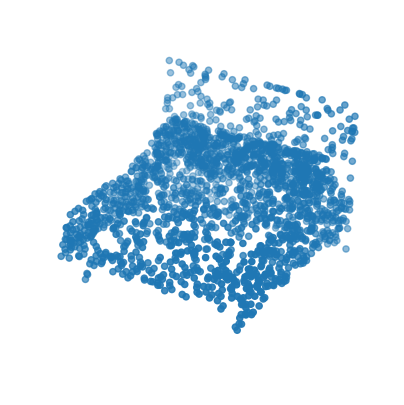

In [ ]:
points_test=trimesh.sample.sample_surface(mesh, count=2048)
faces=points_test[1]
print(faces)
points_test=points_test[0]

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points_test[:, 0], points_test[:, 1], points_test[:, 2])
ax.set_axis_off()
plt.show()


1807


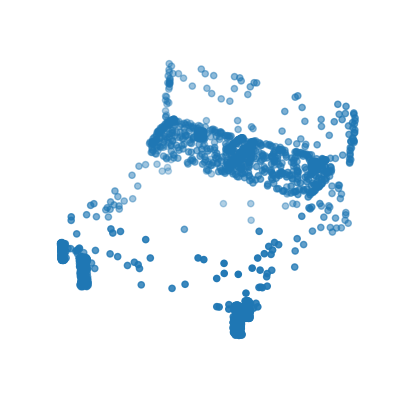

2048


In [ ]:
size = len(mesh.faces)
print(size)
m = 5 # Centre de la distribution
sigma = 1  # Écart type de la distribution

# Générer des coefficients aléatoires avec une distribution normale
random_coefficients = np.random.normal(loc=m, scale=sigma, size=size)
# Échantillonner la surface du maillage avec des poids de face spécifiques
num_points = 2048
# samples, face_index, colors = trimesh.sample.sample_surface(mesh, num_points, face_weight=face_weight, sample_color=True)
samples, face_index, colors = trimesh.sample.sample_surface(mesh, num_points, face_weight=random_coefficients, sample_color=True)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(samples[:, 0], samples[:, 1], samples[:, 2])
ax.set_axis_off()
plt.show()

print(len(samples))

## Function to Parse Data
- Each mesh is loaded and sampled into a point cloud and is returned as a numpy array

In [ ]:
def parse_dataset(num_points=2048):

    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        # gather all files
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))

        for f in train_files:
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)

        for f in test_files:
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)

    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )

In [ ]:
def parse_dataset_test_normal(num_points=2048):
    mesh_points = []
    mesh_labels = []
    class_map = {}
    folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        class_map[i] = folder.split("/")[-1]

        # gather all files
        # files = glob.glob(os.path.join(folder, "*.off"))
        files = glob.glob(os.path.join(folder, "test/*"))

        for f in files:
            # Load the mesh
            mesh = trimesh.load(f)

            # Calculate random coefficients with normal distribution
            size = len(mesh.faces)
            m=5
            sigma=1
            random_coefficients = np.random.normal(loc=m, scale=sigma, size=size)
            points, face_index, colors = trimesh.sample.sample_surface(mesh, num_points, face_weight=random_coefficients, sample_color=True)

            # Extract vertices from the sampled points tuple
            # points_np = points.vertices

            # Append sampled points and label to lists
            mesh_points.append(points)
            mesh_labels.append(i)

    return np.array(mesh_points), np.array(mesh_labels), class_map


## Parse the Dataset and Process each Class

In [ ]:
NUM_POINTS = 2048
NUM_CLASSES = 10
BATCH_SIZE = 32

train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(NUM_POINTS)

processing class: night_stand
processing class: monitor
processing class: chair
processing class: bed
processing class: desk
processing class: bathtub
processing class: sofa
processing class: toilet
processing class: table
processing class: dresser


In [ ]:
NUM_POINTS = 2048
NUM_CLASSES = 10
BATCH_SIZE = 32

test_points_normal, test_labels_normal, CLASS_MAP_normal = parse_dataset_test_normal(num_points=2048)

processing class: night_stand
processing class: monitor
processing class: chair
processing class: bed
processing class: desk
processing class: bathtub
processing class: sofa
processing class: toilet
processing class: table
processing class: dresser


## Augenmentation for Train Dataset

In [ ]:
def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label


train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

In [ ]:
test_dataset_normal = tf.data.Dataset.from_tensor_slices((test_points_normal, test_labels_normal))
test_dataset_normal = test_dataset_normal.shuffle(len(test_points_normal)).batch(BATCH_SIZE)


## Functions to Build the Model

In [ ]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

In [ ]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

## Function to create T-net Layers

In [ ]:
def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

## Create the Convolutional Neural Network

In [ ]:
NUM_POINTS=2048

In [ ]:
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 64)
x = conv_bn(x, 64)
x = tnet(x, 64)
x = conv_bn(x, 64)
x = conv_bn(x, 128)
x = conv_bn(x, 1024)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 512)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()

Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 2048, 3)]            0         []                            
                                                                                                  
 conv1d_22 (Conv1D)          (None, 2048, 32)             128       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_34 (Ba  (None, 2048, 32)             128       ['conv1d_22[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_34 (Activation)  (None, 2048, 32)             0         ['batch_normalization_3

## Compile and Train the Model

In [ ]:
model.load_weights("/content/pointnet_poids.h5")


In [ ]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(train_dataset, epochs=50, validation_data=test_dataset)

Epoch 1/50
125/125 [==============================] - 48s 230ms/step - loss: 3.1809 - sparse_categorical_accuracy: 0.7078 - val_loss: 412441313280.0000 - val_sparse_categorical_accuracy: 0.7401
Epoch 2/50
125/125 [==============================] - 26s 210ms/step - loss: 2.7128 - sparse_categorical_accuracy: 0.8023 - val_loss: 16111825707859968.0000 - val_sparse_categorical_accuracy: 0.7907
Epoch 3/50
125/125 [==============================] - 26s 211ms/step - loss: 2.6762 - sparse_categorical_accuracy: 0.8166 - val_loss: 800293584896.0000 - val_sparse_categorical_accuracy: 0.7731
Epoch 4/50
125/125 [==============================] - 27s 213ms/step - loss: 2.5847 - sparse_categorical_accuracy: 0.8462 - val_loss: 3187623854080.0000 - val_sparse_categorical_accuracy: 0.8117
Epoch 5/50
125/125 [==============================] - 27s 212ms/step - loss: 2.6052 - sparse_categorical_accuracy: 0.8399 - val_loss: 12121942261760.0000 - val_sparse_categorical_accuracy: 0.7874
Epoch 6/50
125/125 [==

In [ ]:
model.save_weights("pointnet_poids_new.h5")


In [ ]:
from google.colab import files
files.download("pointnet_poids_new.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Visualize The Predictions

In [ ]:
samples.shape

(2048, 3)

In [ ]:
samples = np.expand_dims(samples, axis=0)


1/1 [==============================] - 0s 20ms/step


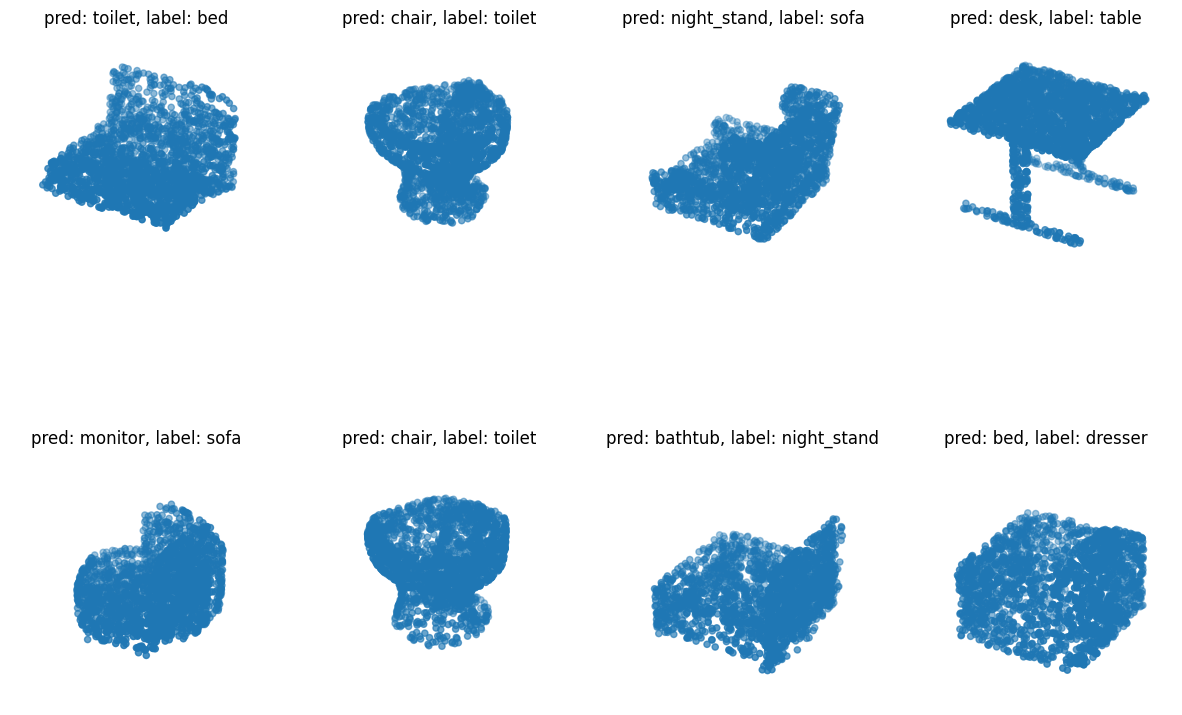

In [ ]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()

## Predictions on unbalanced point sets


1/1 [==============================] - 0s 19ms/step


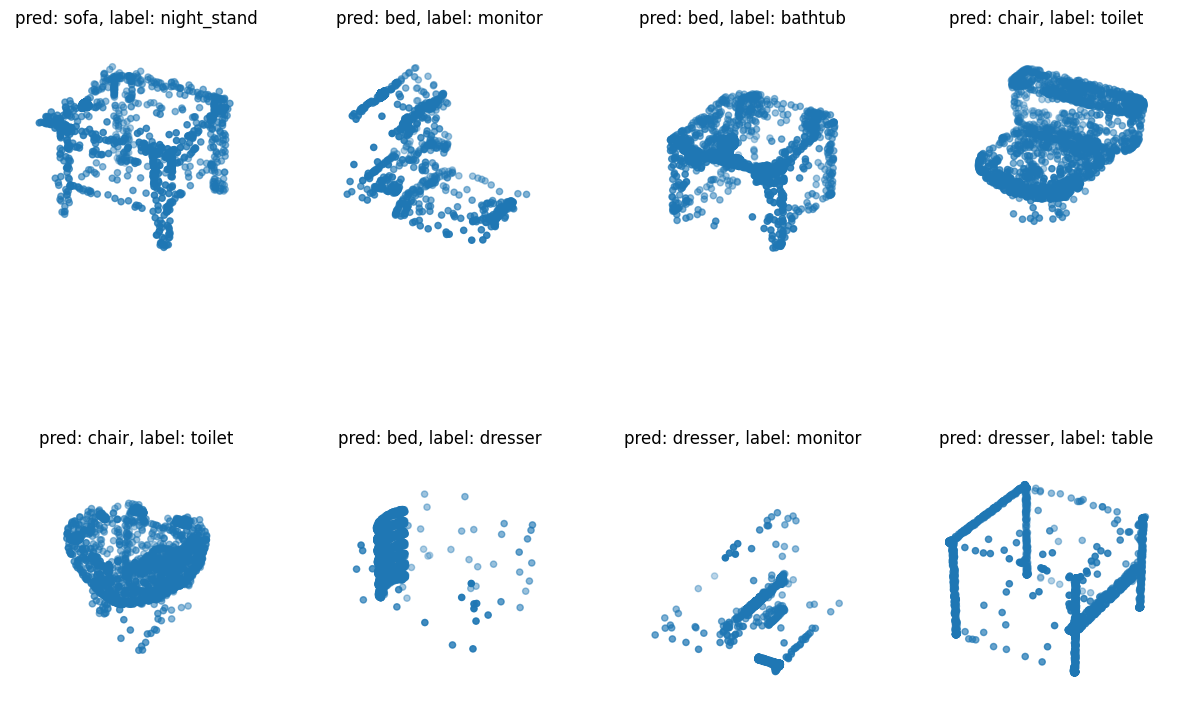

In [ ]:
data_normal = test_dataset_normal.take(1)

points_normal, labels_normal = list(data_normal)[0]
points_normal = points_normal[:8, ...]
labels_normal = labels_normal[:8, ...]

# run test data through model
preds_normal = model.predict(points_normal)
preds_normal = tf.math.argmax(preds_normal, -1)

points_normal = points_normal.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points_normal[i, :, 0], points_normal[i, :, 1], points_normal[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP_normal[preds_normal[i].numpy()], CLASS_MAP_normal[labels_normal.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()

In [ ]:
# Get all test data
test_points, test_labels = [], []
for test_data in test_dataset:
    points, labels = test_data
    test_points.append(points)
    test_labels.append(labels)

test_points = tf.concat(test_points, axis=0)
test_labels = tf.concat(test_labels, axis=0)

# Run test data through model
preds = model.predict(test_points)
preds = tf.math.argmax(preds, axis=-1)

# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(tf.equal(preds, test_labels), dtype=tf.float32)).numpy()
print("Accuracy:", accuracy)


29/29 [==============================] - 2s 44ms/step
Accuracy: 0.79845816


In [ ]:
# Get all test data
test_points_normal, test_labels_normal = [], []
for test_data in test_dataset_normal:
    points, labels = test_data
    test_points_normal.append(points)
    test_labels_normal.append(labels)

test_points_normal = tf.concat(test_points_normal, axis=0)
test_labels_normal = tf.concat(test_labels_normal, axis=0)

# Run test data through model
preds_normal = model.predict(test_points_normal)
preds_normal = tf.math.argmax(preds_normal, axis=-1)

# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(tf.equal(preds_normal, test_labels_normal), dtype=tf.float32)).numpy()
print("Accuracy:", accuracy)



29/29 [==============================] - 1s 43ms/step
Accuracy: 0.7037445


##Contributing points


In [ ]:
intermediate_layer_model = keras.Model(inputs=model.input, outputs=model.layers[-10].input)


In [ ]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

points = points.numpy()

# Get the intermediate outputs
intermediate_outputs=[]
contributing_points=[]
max_indices=[]
for i in range(8):
  # print(points[i],points[i].shape)
  sample = np.expand_dims(points[i], axis=0)
  intermediate_output = intermediate_layer_model.predict(sample)
  intermediate_output=intermediate_output[0]
  # print(intermediate_output.shape)
  # max_indices_i = tf.argmax(intermediate_output, axis=0)
  max_indices_i = np.argmax(intermediate_output, axis=0)
  # print(max_indices_i)
  max_indices.append(max_indices_i)
  # contributing_points_i=tf.gather(points[i], max_indices_i, axis=0)
  contributing_points_i = points[i][max_indices_i]  # Extraction des points correspondants avec les indices

  contributing_points.append(contributing_points_i)

# # Convert to numpy array
contributing_points = np.array(contributing_points)


1/1 [==============================] - 0s 19ms/step


In [ ]:
print(contributing_points[0].shape)
# print(max_indices[0].shape)

(1024, 3)


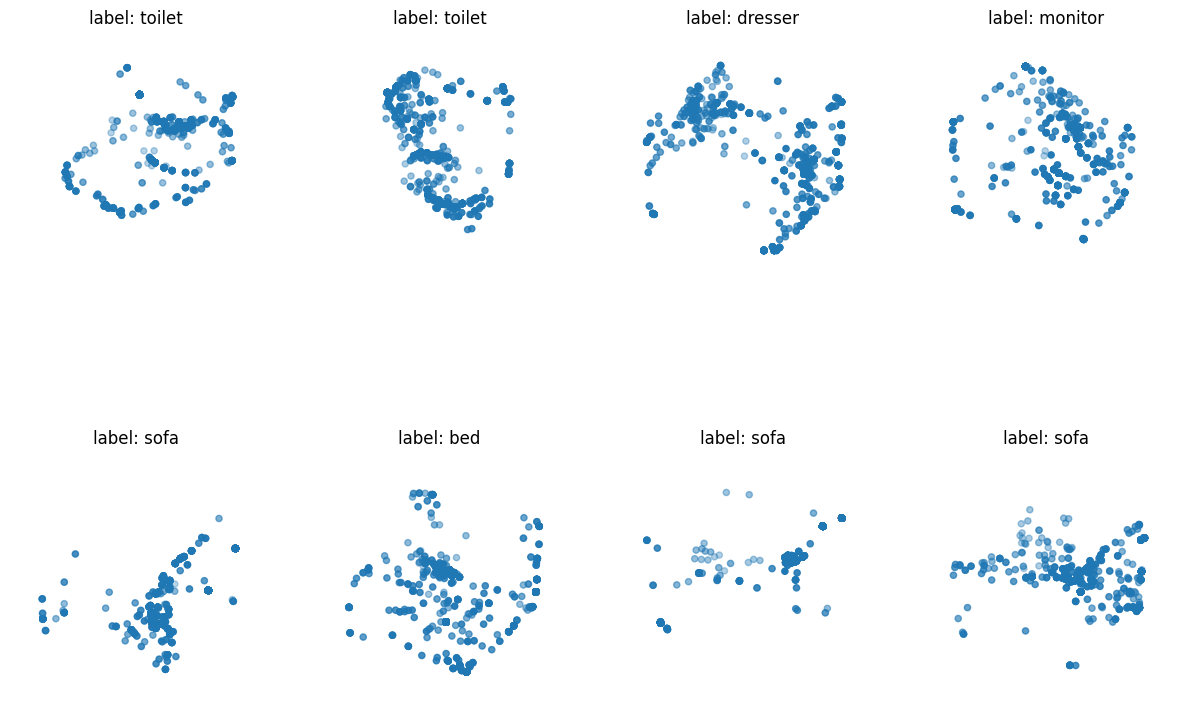

In [ ]:
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(contributing_points[i][:, 0], contributing_points[i][:, 1], contributing_points[i][:, 2])
    ax.set_title(
        "label: {:}".format(
            CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()

## Rotations


On essaiera respectivement des rotations autour de $(Ox), (Oy)$ et $(Oz)$ avec les matrices:
$R_x = \begin{pmatrix}
1 & 0 & 0 \\
0 & \cos(\theta) & -\sin(\theta) \\
0 & \sin(\theta) & \cos(\theta)
\end{pmatrix}$

$R_y = \begin{pmatrix}
\cos(\theta) & 0 & \sin(\theta) \\
0 & 1 & 0 \\
-\sin(\theta) & 0 & \cos(\theta)
\end{pmatrix}$

et
$R_z = \begin{pmatrix}
\cos(\theta) & -\sin(\theta) & 0 \\
\sin(\theta) & \cos(\theta) & 0 \\
0 & 0 & 1
\end{pmatrix}$




In [ ]:
def Rx(teta):
  return np.array([[np.cos(teta),0,np.sin(teta)],[0,1,0],[-np.sin(teta),0,np.cos(teta)]])

def Ry(teta):
  return np.array([[np.cos(teta),-np.sin(teta),0],[np.sin(teta),np.cos(teta),0],[0,0,1]])

def Rz(teta):
  return np.array([[1,0,0],[0,np.cos(teta),np.sin(teta)],[0,np.sin(teta),np.cos(teta)]])



In [ ]:
teta=np.random.uniform(0, 2*np.pi)
print(teta)
rotx=Rx(teta)
roty=Ry(teta)
rotz=Rz(teta)

0.3142548892130149


In [ ]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

points = points.numpy()
def rotate(Rotation_matrix,cloud):
  return (Rotation_matrix @ (cloud.T)).T

def rotate_point_clouds(Rotation_matrix,points):
  rotated=[]
  for cloud in points:
    rotated.append(rotate(Rotation_matrix,cloud))
  return np.stack(rotated)

points_rotated=rotate_point_clouds(rotz,points)


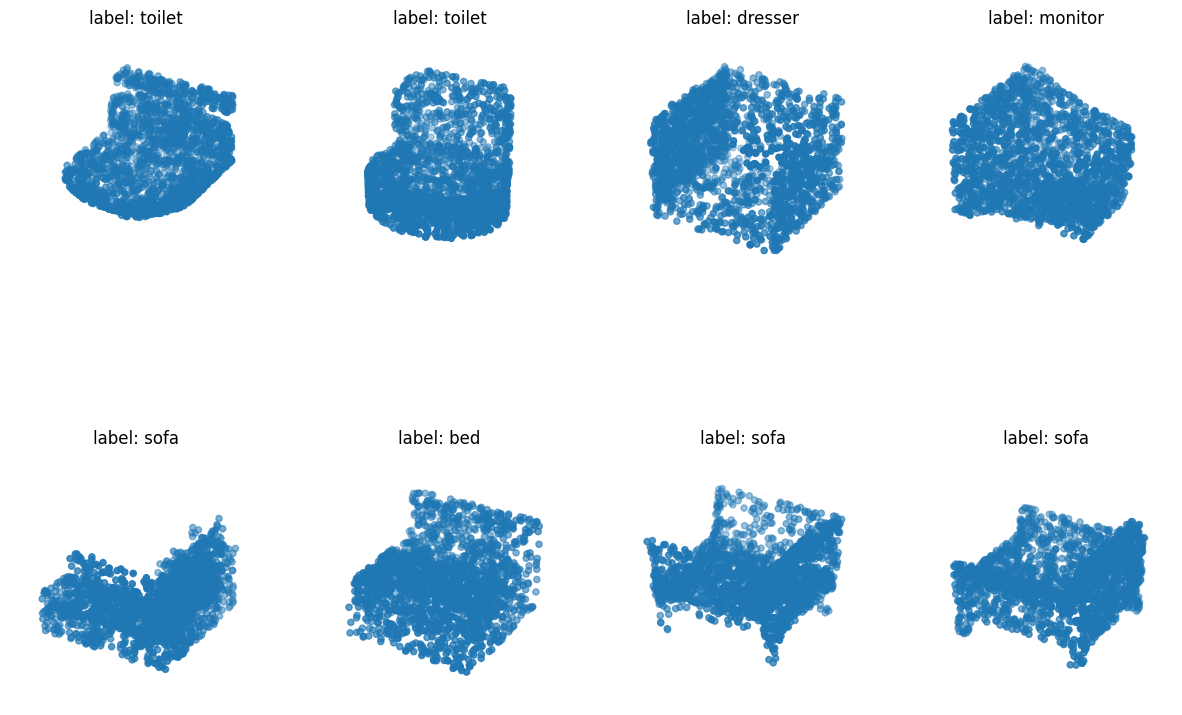

In [ ]:
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i][:, 0], points[i][:, 1],points[i][:, 2])
    ax.set_title(
        "label: {:}".format(
            CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()

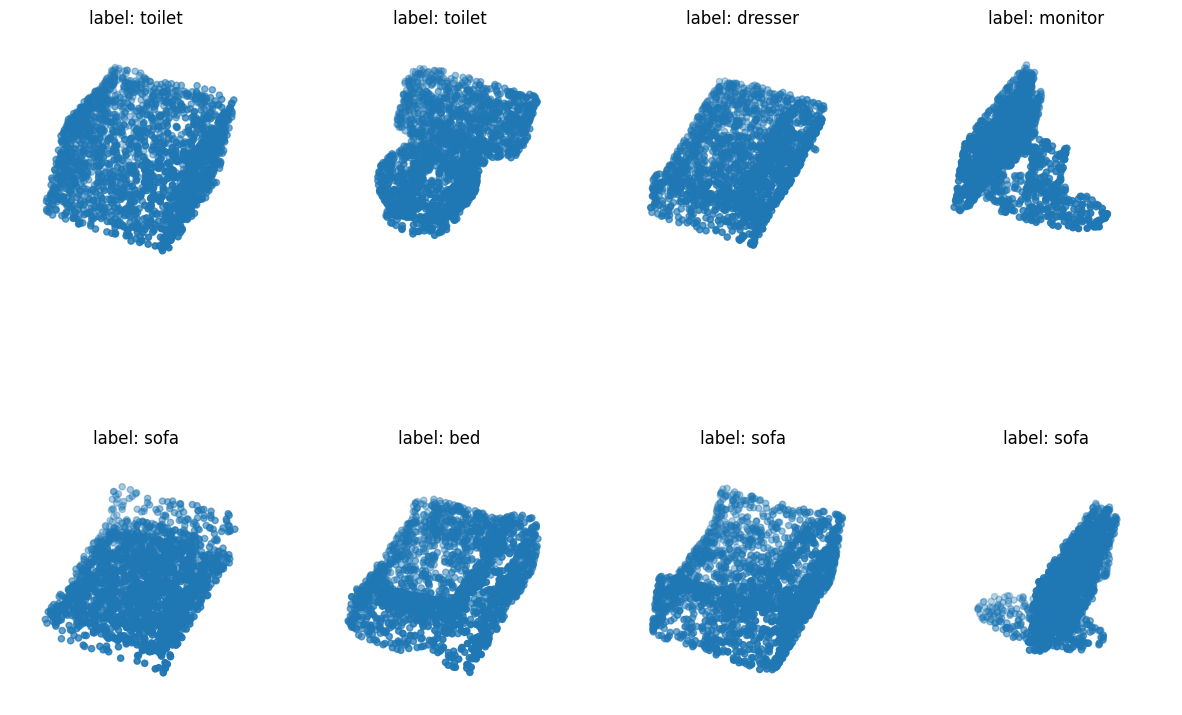

In [ ]:
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points_rotated[i][:, 0], points_rotated[i][:, 1],points_rotated[i][:, 2])
    ax.set_title(
        "label: {:}".format(
            CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()

Testing accuracy if points are rotated

In [ ]:
teta=np.random.uniform(0, 2*np.pi)
print(teta)
rotx=Rx(teta)
roty=Ry(teta)
rotz=Rz(teta)

2.077011429557175


In [ ]:
# Get all test data
test_points, test_labels = [], []
for test_data in test_dataset:
    points, labels = test_data
    for i in range(len(points)):
      test_points.append(points.numpy()[i,:,:])
      test_labels.append(labels[i])

test_points=np.stack(test_points)

def test_accuracy_rotations(rot):
  test_points_rotated=rotate_point_clouds(rot,test_points)
  # Run test data through model
  preds = model.predict(test_points_rotated)
  preds=np.argmax(preds, axis=1)
  # # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(tf.equal(preds, test_labels), dtype=tf.float32)).numpy()
  return accuracy

for i in range(10):
  teta=np.random.uniform(0, 2*np.pi)
  rotx=Rx(teta)
  print('with the rotation along the x axis of {} accuracy is: {}'.format(teta,test_accuracy_rotations(rotx)))
  roty=Ry(teta)
  print('with the rotation along the y axis of {} accuracy is: {}'.format(teta,test_accuracy_rotations(roty)))
  rotz=Rz(teta)
  print('with the rotation along the z axis of {} accuracy is: {}'.format(teta,test_accuracy_rotations(rotz)))


29/29 [==============================] - 2s 43ms/step
with the rotation along the x axis of 1.1888271964108947 accuracy is: 0.25330397486686707
29/29 [==============================] - 1s 42ms/step
with the rotation along the y axis of 1.1888271964108947 accuracy is: 0.3590308427810669
29/29 [==============================] - 1s 42ms/step
with the rotation along the z axis of 1.1888271964108947 accuracy is: 0.2290748953819275
29/29 [==============================] - 1s 42ms/step
with the rotation along the x axis of 4.5401597846537936 accuracy is: 0.15969163179397583
29/29 [==============================] - 1s 43ms/step
with the rotation along the y axis of 4.5401597846537936 accuracy is: 0.34251102805137634
29/29 [==============================] - 1s 42ms/step
with the rotation along the z axis of 4.5401597846537936 accuracy is: 0.39647576212882996
29/29 [==============================] - 1s 44ms/step
with the rotation along the x axis of 4.530966201506048 accuracy is: 0.1552863419055

## Augmenting training dataset with rotated points

In [ ]:
def rotate(points, label, k):
    rotated_points = []
    rotated_labels = []
    for _ in range(k):
        # Générer des angles aléatoires pour chaque rotation autour de chaque axe
        angle_x = np.random.uniform(0, 2 * np.pi)
        angle_y = np.random.uniform(0, 2 * np.pi)
        angle_z = np.random.uniform(0, 2 * np.pi)

        # Construire les matrices de rotation autour de chaque axe
        Rx_matrix = Rx(angle_x)
        Ry_matrix = Ry(angle_y)
        Rz_matrix = Rz(angle_z)

        # Combiner les rotations en une seule matrice de rotation
        Rotation_matrix = np.dot(np.dot(Rz_matrix, Ry_matrix), Rx_matrix)

        # Effectuer la rotation des points
        rotated = rotate_point_clouds(Rotation_matrix, points)

        # Ajouter les points et les étiquettes à la liste
        rotated_points.append(rotated)
        rotated_labels.append(label)

    # Concaténer les listes de points et de labels
    augmented_points = np.concatenate(rotated_points, axis=0)
    augmented_labels = np.concatenate(rotated_labels, axis=0)

    return augmented_points, augmented_labels
